In [1]:
import numpy as np
import joblib
import glob
import os
import random
import numpy as np
import torch

SEED_VALUE = 0
os.environ["PYHTONSEED"] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)

from matplotlib import pyplot as plt
%config InlineBackend.figure_gformat = "retina"
%matplotlib inline

from sklearn.metrics import mean_squared_error

In [2]:
rmse_10_list = []
rmse_20_list = []
rmse_40_list = []
rmse_100_list = []
rmse_200_list = []
rmse_500_list = []
rmse_1000_list = []


for f in glob.glob('results/results_240830082727/interpret_results_*.pkl'):
    chem_name = f.split("interpret_results_")[1].split("_")[0]
    results = joblib.load(f'{f}')
    
    true_ig = results["x"].cpu() * results["IG"].cpu().numpy()
    
    all_ig = results["x"].cpu() * results["GP_IG"][:,:].cpu().numpy()
    
    ig_10 = all_ig[:10,:].mean(axis=0)
    ig_20 = all_ig[:20,:].mean(axis=0)
    ig_40 = all_ig[:40,:].mean(axis=0)
    ig_100 = all_ig[:100,:].mean(axis=0)
    ig_200 = all_ig[:200,:].mean(axis=0)
    ig_500 = all_ig[:500,:].mean(axis=0)
    ig_1000 = all_ig[:1000,:].mean(axis=0)
    
    rmse_10_list.append(mean_squared_error(ig_10, true_ig, squared=False))
    rmse_20_list.append(mean_squared_error(ig_20, true_ig, squared=False))
    rmse_40_list.append(mean_squared_error(ig_40, true_ig, squared=False))
    rmse_100_list.append(mean_squared_error(ig_100, true_ig, squared=False))
    rmse_200_list.append(mean_squared_error(ig_200, true_ig, squared=False))
    rmse_500_list.append(mean_squared_error(ig_500, true_ig, squared=False))
    rmse_1000_list.append(mean_squared_error(ig_1000, true_ig, squared=False))

Text(0.5, 1.0, 'GPR trained with 200 data')

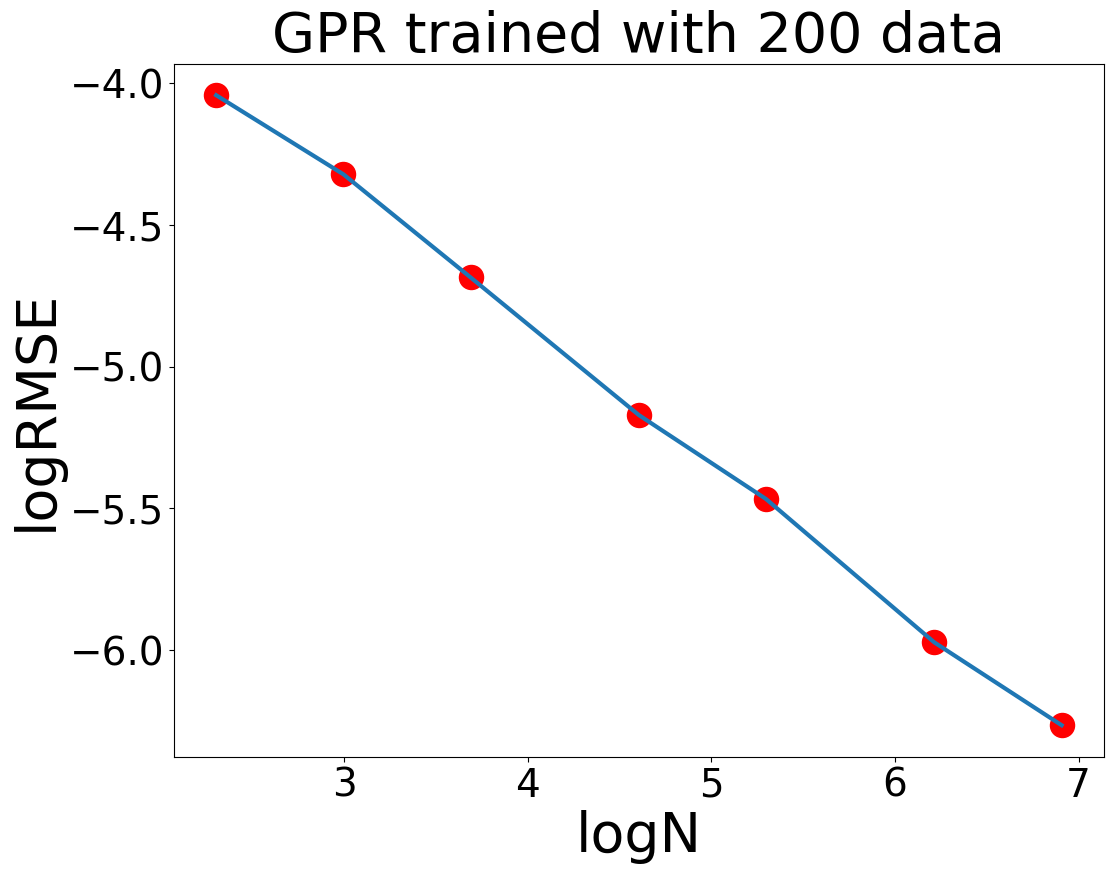

In [3]:
n_iter = [10, 20, 40, 100, 200, 500, 1000]
rmse_list = [np.mean(rmse_10_list), np.mean(rmse_20_list), np.mean(rmse_40_list), np.mean(rmse_100_list), np.mean(rmse_200_list), np.mean(rmse_500_list), np.mean(rmse_1000_list)]
log_rmse_list = [np.log(i) for i in rmse_list]
log_n_iter = [np.log(i) for i in n_iter]

plt.figure(figsize=(12,9))
plt.xlabel('logN', fontsize=40)
plt.ylabel('logRMSE', fontsize=40)
plt.plot(log_n_iter, log_rmse_list, linewidth=3)
plt.scatter(log_n_iter, log_rmse_list, marker='o', c="red", s=300, alpha=1)
plt.tick_params(labelsize=28)
plt.title("GPR trained with 200 data", fontsize=40)

In [4]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem,Draw, Descriptors, PandasTools, Descriptors3D
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import SaltRemover
from rdkit.Chem import rdMolDescriptors
from collections import defaultdict
from rdkit import DataStructs
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

def interpret(bits_name, bits_importance, mol, name=None):
    names = bits_name
    bits = []

    for i in range(len(names)):
        bits.append(int(names[i])) 

    coef = bits_importance
    
    bit_coef = dict(zip(bits, coef))

    #Calculate Fingerprints
    bitI_morgan = {}
    fp_morgan = AllChem.GetMorganFingerprint(mol, 2, bitInfo=bitI_morgan)

    #Extracting contributing bits
    bit_list = list(set(bits)&set(bitI_morgan.keys()))
    
    #Generate an array to store contributions
    Ai_list = np.zeros(mol.GetNumAtoms())

    for bit in bit_list:

        #Fingerprint Contribution
        Cn = bit_coef[int(bit)]

        #Number of substructures in a molecule
        fn = len(bitI_morgan[bit])

        for part in bitI_morgan[bit]:
            
            #If the radius of the fingerprint is 0, the central atom of the fingerprint is extracted and its contribution is added.
            if part[1]==0:
                i = part[0]
                xn = 1
                Ai_list[i] += Cn / fn / xn

            #If the fingerprint's radious is greater than or equal to 0, extract a list of the corresponding atoms and add their contributions.
            else:
                amap={}
                env = Chem.FindAtomEnvironmentOfRadiusN(mol,
                                                        radius=part[1],
                                                        rootedAtAtom=part[0])
                submol=Chem.PathToSubmol(mol,env,atomMap=amap)

                #Number of atoms in each substructure
                xn = len(list(amap.keys()))

                for i in amap.keys():
                    Ai_list[i] += Cn / fn / xn

    Ai_list = Ai_list / abs(Ai_list).max() * 0.5
    
    atoms = [i for i in range(len(Ai_list))]
    atom_colors = dict()
    for i in atoms:
        if Ai_list[i] > 0:
            atom_colors[i] = (1,1-Ai_list[i],1-Ai_list[i])
        else:
            atom_colors[i] = (1+Ai_list[i],1+Ai_list[i],1)

    view = rdMolDraw2D.MolDraw2DSVG(500,500)
    tm = rdMolDraw2D.PrepareMolForDrawing(mol)

    view.DrawMolecule(tm,
                      highlightAtoms=atoms,
                      highlightAtomColors=atom_colors,
                      highlightBonds=[],
                      highlightBondColors={})

    view.FinishDrawing()
    svg = view.GetDrawingText()
    
    return SVG(svg)

RDKit WARNING: [08:51:22] Enabling RDKit 2019.09.3 jupyter extensions
[08:51:22] Enabling RDKit 2019.09.3 jupyter extensions


In [5]:
import pandas as pd
df = pd.read_csv("data/delaney-processed.csv",index_col=0)
df.head()

,measured log solubility in mols per litre,smiles
Compound ID,,
Amigdalin,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
Fenfuram,-3.30,Cc1occc1C(=O)Nc2ccccc2
citral,-2.06,CC(C)=CCCC(C)=CC(=O)
Picene,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
Thiophene,-1.33,c1ccsc1


2,4-Dimethyl-2-pentanol 
y:-0.92,f_mean:-2.65,f_std:0.46
f_mean


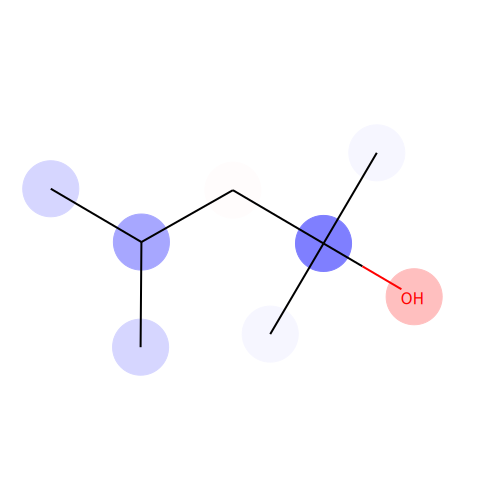

f_std


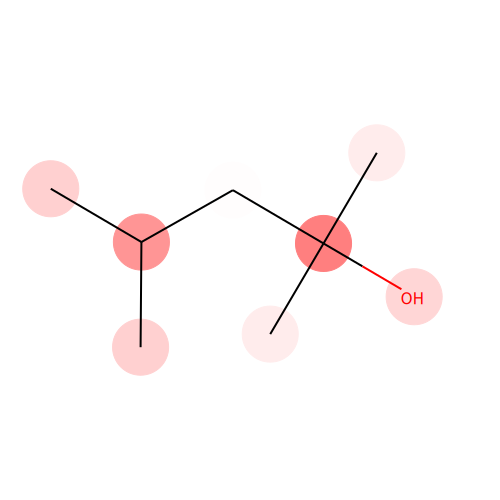

Sucrose
y:0.79,f_mean:-1.62,f_std:1.30
f_mean


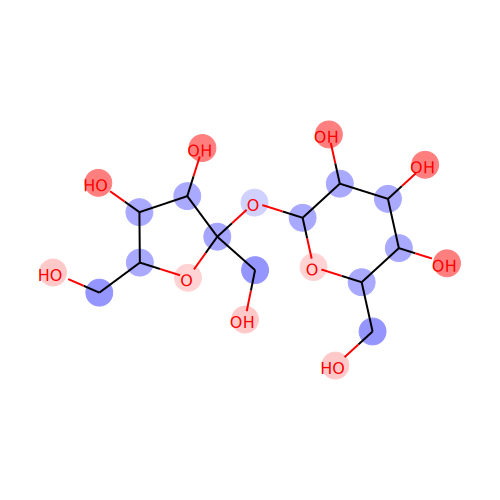

f_std


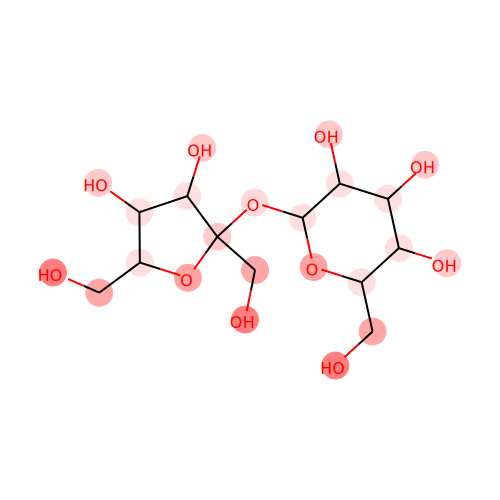

In [6]:
import joblib

test_name_list = ["2,4-Dimethyl-2-pentanol ", "Sucrose"]

for test_name in test_name_list:
    print(test_name)
    save =False
    
    folder = "results/results_240830082727"
    f=f"{folder}/interpret_results_{test_name}_240830082727.pkl"

    results = joblib.load(f'{f}')
    print(f"y:{results['y'][0]:.2f},f_mean:{results['f_pred_mean'][0]:.2f},f_std:{results['f_pred_var'][0]**0.5:.2f}")
    mol = Chem.MolFromSmiles(df.loc[results["test_index"],"smiles"])
    bits_name = results["x_name"]
    
    gp_ig = results["GP_IG"] * results["x"]
    
    bits_importance = gp_ig.mean(axis=0)
    print("f_mean")
    display(interpret(bits_name, bits_importance, mol, name=f"{folder}/{test_name}_GP_mean",save=save))
    print("f_std")
    bits_importance = gp_ig.std(axis=0)
    display(interpret(bits_name, bits_importance, mol,  name=f"{folder}/{test_name}_GP_std", save=save))

2,4-Dimethyl-2-pentanol 
y:-0.92,f_mean:-2.65,f_std:0.46


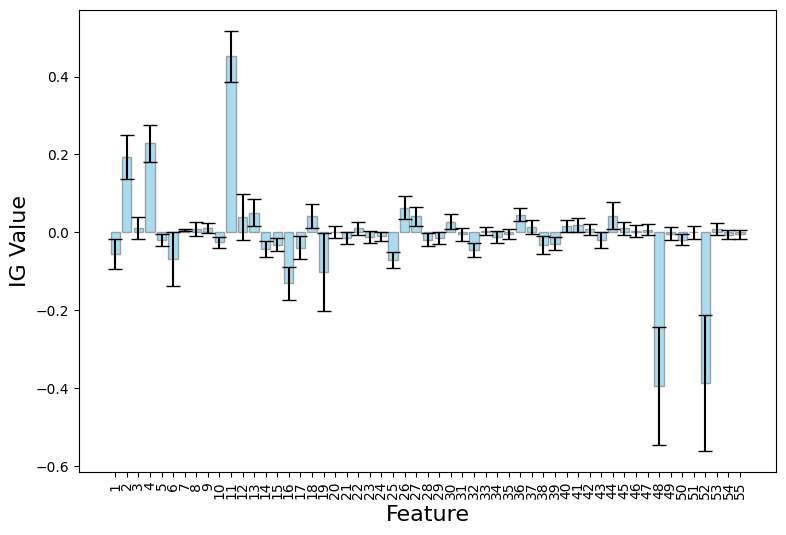

Sucrose
y:0.79,f_mean:-1.62,f_std:1.30


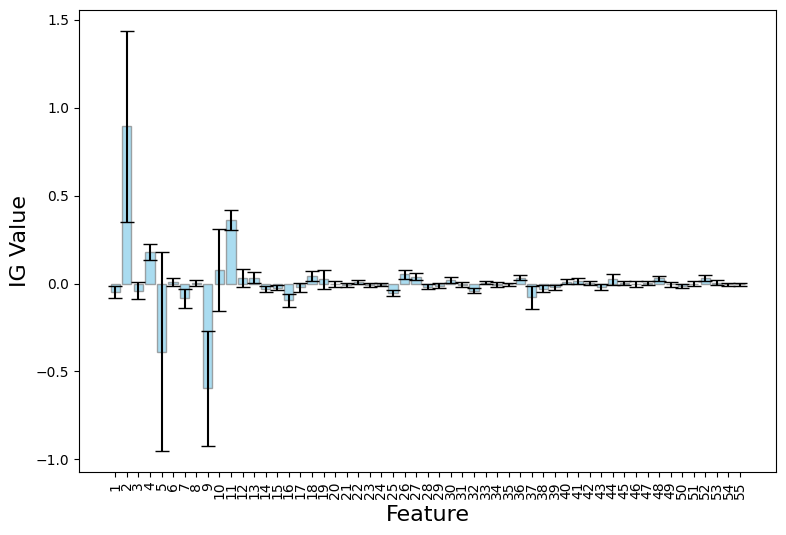

In [7]:
test_name_list = ["2,4-Dimethyl-2-pentanol ", "Sucrose"]

for test_name in test_name_list:
    print(test_name)
    
    folder = "results/results_240830082727"
    f=f"{folder}/interpret_results_{test_name}_240830082727.pkl"

    results = joblib.load(f'{f}')

    print(f"y:{results['y'][0]:.2f},f_mean:{results['f_pred_mean'][0]:.2f},f_std:{results['f_pred_var'][0]**0.5:.2f}")
    gp_ig = results["GP_IG"] * results["x"]

    x = np.arange(1, gp_ig.shape[1]+1)
    plt.figure(figsize=(9, 6))
    plt.bar(x, gp_ig.mean(axis=0), yerr=gp_ig.std(axis=0), capsize=5, color='skyblue', alpha=0.7, edgecolor='grey')
    plt.xlabel('Feature', fontsize=16)
    plt.ylabel('IG Value', fontsize=16)
    plt.xticks(x, rotation=90)
    plt.show()